In [117]:
import pandas as pd
import spacy
import textacy
import os
import logging
HOME = os.getcwd()
df = pd.read_csv(os.path.join(HOME, 'stem_cell_2018_20210703.csv'), usecols = ['parsed'])
#preproc = textacy.preprocessing.make_pipeline(textacy.preprocessing.normalize.unicode,textacy.preprocessing.normalize.quotation_marks,textacy.preprocessing.normalize.whitespace)
#preproc_records = ((preproc(text), meta) for text, meta in records)
parsed_paragraphs= df.parsed.to_list()
for parsed_paragraph in parsed_paragraphs:
    parsed_paragraph.encode().decode("utf-8")
corpus = textacy.Corpus("en_core_web_sm", data=parsed_paragraphs)
#print(parsed_paragraphs)

['This study protocol represents a sub‐study of a parent prospective randomized study comparing the effects of repetitive and single‐dose cell therapy in patients with nonischemic DCM (\n ', 'This is a single-arm, open-label, multicenter phase I study involving four institutions: Hokkaido University Hospital, St. Marianna University School of Medicine Hospital, National Hospital Organization Nagoya Medical Center, and Kyushu University Hospital. The protocol has been reviewed and approved by institutional review boards of each institutions.', 'Written informed consent regarding participation in this clinical study could be obtained from subjects and/or representatives', 'In subjects treated with this drug, the following assessments should be performed 28\xa0days (7\xa0days) after the final administration if it does not exceed the data cut-off day. These assessments should be conducted before the start of posttreatment. If examinations/observation/surveys are impossible for unavoidable 

In [118]:
import textacy.extract
list(textacy.extract.entities(corpus[0]))

[DCM]

In [119]:
from functools import partial
terms = list(textacy.extract.terms(
     corpus[0],
     ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ"}),
     ents=partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"}),
     dedupe=False))
terms

[study protocol,
 parent prospective,
 prospective randomized,
 randomized study,
 single‐dose cell,
 cell therapy,
 DCM]

In [120]:
list(textacy.extract.terms_to_strings(terms, by="lemma"))


['study protocol',
 'parent prospective',
 'prospective randomized',
 'randomized study',
 'single‐dose cell',
 'cell therapy',
 'DCM']

In [121]:
docs_terms = (
     textacy.extract.terms(
         doc,
         ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ"}),
         ents=partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"}))
     for doc in corpus)
tokenized_docs = (
     textacy.extract.terms_to_strings(doc_terms, by="lemma")
     for doc_terms in docs_terms)

In [122]:
import textacy.representations
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs, tf_type="linear", idf_type="smooth")
doc_term_matrix

<77x782 sparse matrix of type '<class 'numpy.float64'>'
	with 962 stored elements in Compressed Sparse Row format>

In [123]:
import textacy.tm
model = textacy.tm.TopicModel("nmf", n_topics=2)
model.fit(doc_term_matrix)

c:\users\shweata\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [124]:
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

(77, 2)

In [125]:

doc_topic_matrix

array([[0.00000000e+00, 1.69003905e-03],
       [0.00000000e+00, 3.35148579e-02],
       [0.00000000e+00, 1.77437702e-02],
       [0.00000000e+00, 1.12701724e-04],
       [0.00000000e+00, 2.28227429e-01],
       [0.00000000e+00, 1.81154597e-02],
       [0.00000000e+00, 3.83553143e-02],
       [1.32158808e-02, 5.54389020e-02],
       [0.00000000e+00, 1.98474398e-02],
       [1.32853450e-02, 4.12391219e-02],
       [0.00000000e+00, 5.64476508e-04],
       [0.00000000e+00, 2.54128669e-02],
       [0.00000000e+00, 1.91319370e-02],
       [0.00000000e+00, 1.78634439e-02],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.10365772e-03],
       [0.00000000e+00, 1.12701724e-04],
       [0.00000000e+00, 1.06290830e-01],
       [0.00000000e+00, 2.20785737e-02],
       [0.00000000e+00, 6.97572425e-02],
       [0.00000000e+00, 2.66733999e-02],
       [0.00000000e+00, 7.58665994e-02],
       [1.33699156e-02, 2.47352011e-02],
       [0.00000000e+00, 2.88710991e-02],
       [1.364518

In [126]:
id_to_term = {id_: term for term, id_ in vocab.items()}
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=8):
     print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: research funding   Bristol Myers Squibb   Takeda   board participation   advisory board   Karyopharm   Janssen Pharmaceuticals   Amgen
topic 1: cord blood   umbilical cord   blood unit   medical record   month post‐infusion   autologous umbilical   single intravenous   ASD


In [ ]:
for topic_idx, doc_idxs in model.top_topic_docs(doc_topic_matrix, top_n=3):
     print(f"topic {topic_idx}: {'   '.join(corpus[doc_idx]._.meta['title'] for doc_idx in doc_idxs)}")

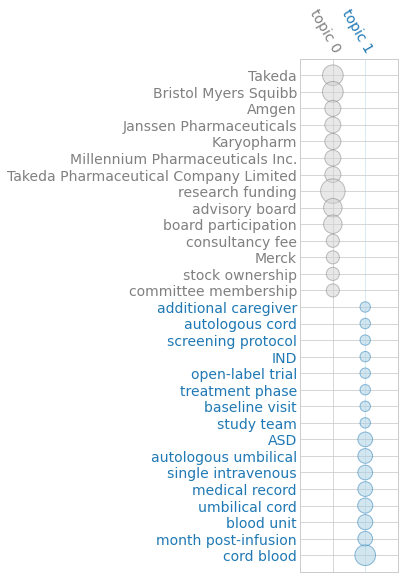

In [127]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[1, 2, 3, 4, 5])